In [47]:
# --- Célula 1: Configuração Inicial e Importações ---

import fastf1
from fastf1 import plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from matplotlib.ticker import FuncFormatter, MultipleLocator

# --- FastF1 Cache Configuration ---
# Creates a cache directory for FastF1 to store downloaded data, speeding up future loads.
# It's recommended to place this in a stable location, e.g., your project root.
CACHE_DIR = './fastf1_cache'
if not os.path.exists(CACHE_DIR):
    os.makedirs(CACHE_DIR)
fastf1.Cache.enable_cache(CACHE_DIR)
print(f"FastF1 cache enabled at: {os.path.abspath(CACHE_DIR)}")

# --- Base Directory for Processed Data (for saving plots if needed) ---
# This is where generated plots might be stored if plt.savefig() is used.
# The data itself will be loaded directly from FastF1 sessions.
BASE_PLOT_DIR = './f1_plots'
if not os.path.exists(BASE_PLOT_DIR):
    os.makedirs(BASE_PLOT_DIR)
print(f"Base directory for saving plots: {os.path.abspath(BASE_PLOT_DIR)}")

# --- Matplotlib Global Style (Optional) ---
# You can set a global style or apply it within each plotting function
plt.style.use('dark_background') # Example: using a dark theme
# plt.rcParams['figure.figsize'] = [12, 8] # Optional: default figure size
# plt.rcParams['figure.dpi'] = 100 # Optional: default figure DPI
COMPOUND_COLORS = fastf1.plotting.COMPOUND_COLORS

FastF1 cache enabled at: c:\Users\mpoli\Desktop\UFOP\8 PERIODO\PAE\Trabalho\fastf1_cache
Base directory for saving plots: c:\Users\mpoli\Desktop\UFOP\8 PERIODO\PAE\Trabalho\f1_plots


C:\Users\mpoli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\fastf1\plotting\__init__.py:84: FutureWarning: INCOMPATIBLE with 2025 season! COMPOUND_COLORS is deprecated and will be removed in a future version.
  warnings.warn(f"INCOMPATIBLE with 2025 season! {name} is deprecated "


# Auxiliar Functions


In [48]:
def format_laptime_mmssms(seconds: float) -> str:
    """
    Converts a time in seconds to MM:SS.ms format.
    Handles NaN values by returning an empty string.
    """
    if pd.isna(seconds):
        return ""
    minutes = int(seconds // 60)
    remaining_seconds = seconds % 60
    return f"{minutes:02d}:{remaining_seconds:06.3f}"

def get_clean_laps(session_laps: pd.DataFrame) -> pd.DataFrame:
    """
    Filters a FastF1 laps DataFrame to return only 'clean' laps,
    excluding laps under Safety Car, Virtual Safety Car, and pit lane entries/exits.
    """
    # Return where lap[‘IsAccurate’] is True
    # Fastf1 has a column 'IsAccurate' that indicates if the lap is accurate and seems to work well
    # First laps are often not accurate, so we filter them out, and also exclude laps with no time and pit in/out laps
    clean_laps = session_laps[session_laps['IsAccurate'] == True]

    return clean_laps.reset_index(drop=True)


# Loading a single race

In [49]:
TARGET_YEAR = 2025
TARGET_ROUND = 11

print(f"Loading session data for {TARGET_YEAR} Round {TARGET_ROUND}...")
try:
    current_session = fastf1.get_session(TARGET_YEAR, TARGET_ROUND, 'R') # 'R' for Race
    
    # Load all data, including telemetry, as you might need it for deeper analysis later
    # This might take longer but loads everything once.
    current_session.load(laps=True, telemetry=True, weather=True, messages=True) 
    
    # Store key DataFrames for easy access in subsequent cells
    laps_df = current_session.laps.copy()
    results_df = current_session.results.copy()
    
    # Add LapTime_seconds to laps_df if not already there (FastF1 provides LapTime as timedelta)
    if 'LapTime_seconds' not in laps_df.columns:
        laps_df['LapTime_seconds'] = laps_df['LapTime'].dt.total_seconds()

    race_name = current_session.event['EventName']
    
    print(f"Session data loaded for: {race_name} {TARGET_YEAR} Round {TARGET_ROUND}")
    print(f"Total laps: {len(laps_df)}, Total results: {len(results_df)}")
except Exception as e:
    print(f"Error loading FastF1 session: {e}")
    current_session = None
    laps_df = pd.DataFrame()
    results_df = pd.DataFrame()
    race_name = "N/A"


Loading session data for 2025 Round 11...


core           INFO 	Loading data for Austrian Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['4', '81', '16', '44', '63', '30', '14', '5', '27', '31', '87', '6', '10', '18', '43', '22', '23', '1', '12', '55']


Session data loaded for: Austrian Grand Prix 2025 Round 11
Total laps: 1127, Total results: 20


## Top 10's stint

Plotting the stints of the top 10 drivers in the selected season.

The auxiliar function `get_clean_laps` clean the laps data, excluding starts, pit stops and SC and VSC laps.

['NOR' 'PIA' 'LEC' 'HAM' 'RUS' 'LAW' 'ALO' 'BOR' 'HUL' 'OCO']


C:\Users\mpoli\AppData\Local\Temp\ipykernel_22088\4228898672.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  driver_laps['LapTime_formatted'] = driver_laps['LapTime_seconds'].apply(format_laptime_mmssms)


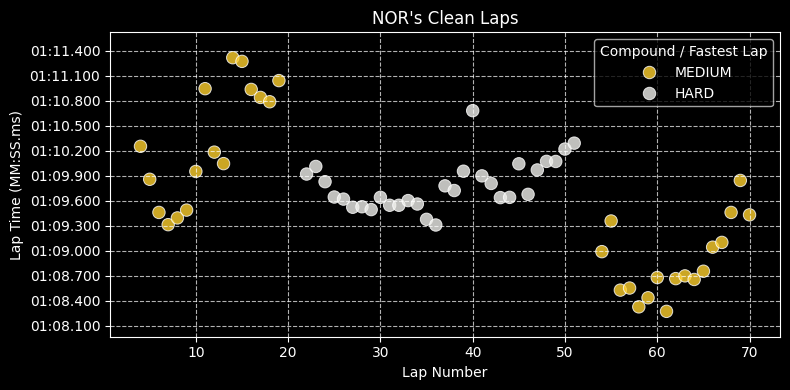

C:\Users\mpoli\AppData\Local\Temp\ipykernel_22088\4228898672.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  driver_laps['LapTime_formatted'] = driver_laps['LapTime_seconds'].apply(format_laptime_mmssms)


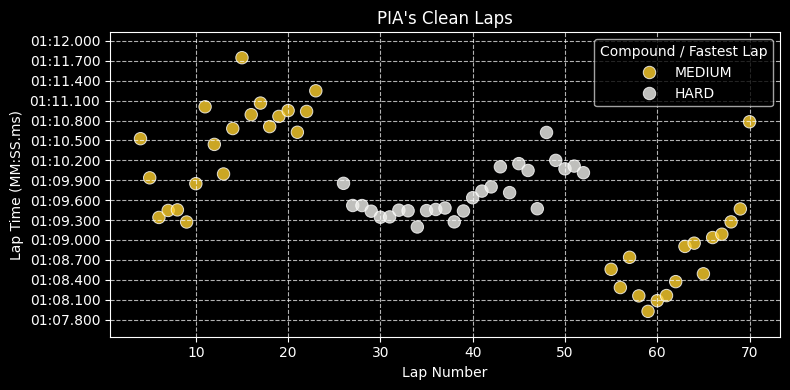

C:\Users\mpoli\AppData\Local\Temp\ipykernel_22088\4228898672.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  driver_laps['LapTime_formatted'] = driver_laps['LapTime_seconds'].apply(format_laptime_mmssms)


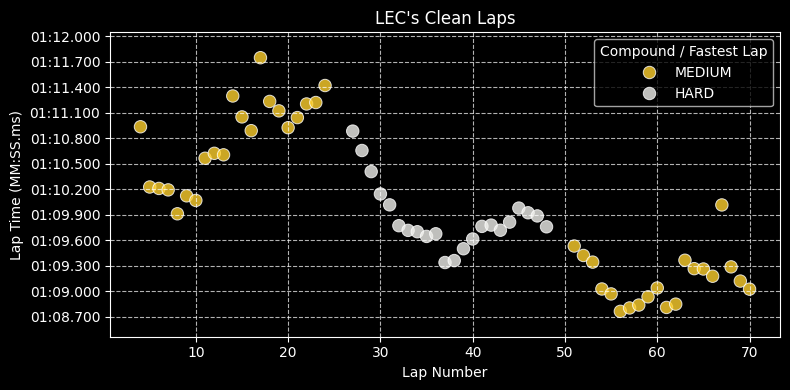

C:\Users\mpoli\AppData\Local\Temp\ipykernel_22088\4228898672.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  driver_laps['LapTime_formatted'] = driver_laps['LapTime_seconds'].apply(format_laptime_mmssms)


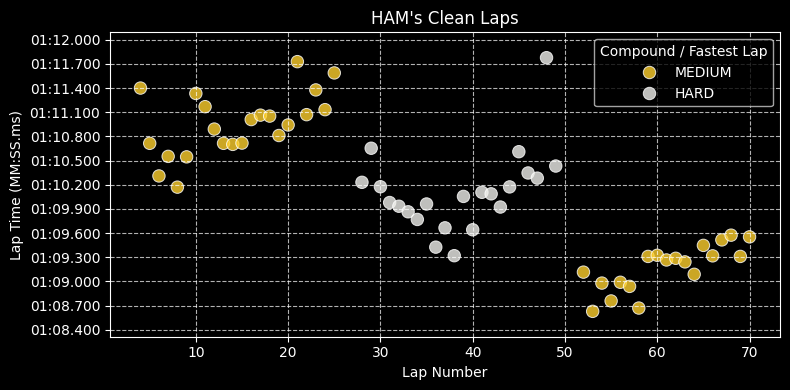

C:\Users\mpoli\AppData\Local\Temp\ipykernel_22088\4228898672.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  driver_laps['LapTime_formatted'] = driver_laps['LapTime_seconds'].apply(format_laptime_mmssms)


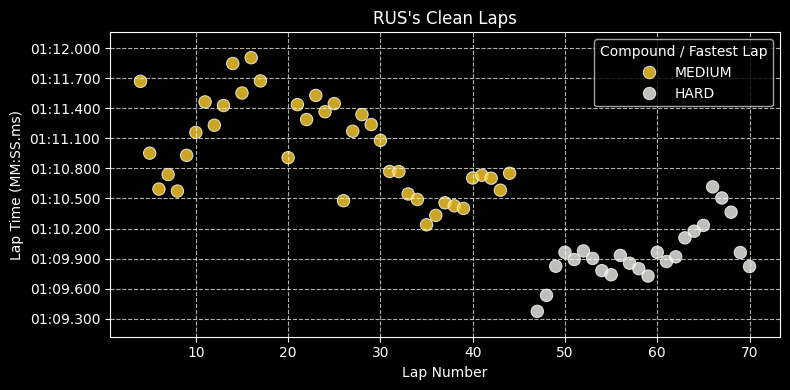

C:\Users\mpoli\AppData\Local\Temp\ipykernel_22088\4228898672.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  driver_laps['LapTime_formatted'] = driver_laps['LapTime_seconds'].apply(format_laptime_mmssms)


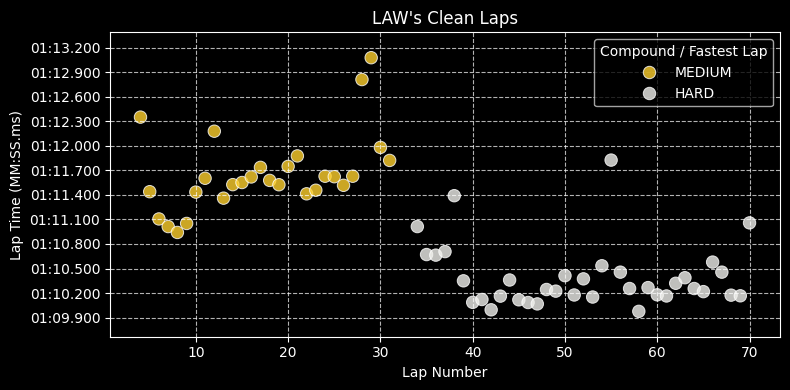

C:\Users\mpoli\AppData\Local\Temp\ipykernel_22088\4228898672.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  driver_laps['LapTime_formatted'] = driver_laps['LapTime_seconds'].apply(format_laptime_mmssms)


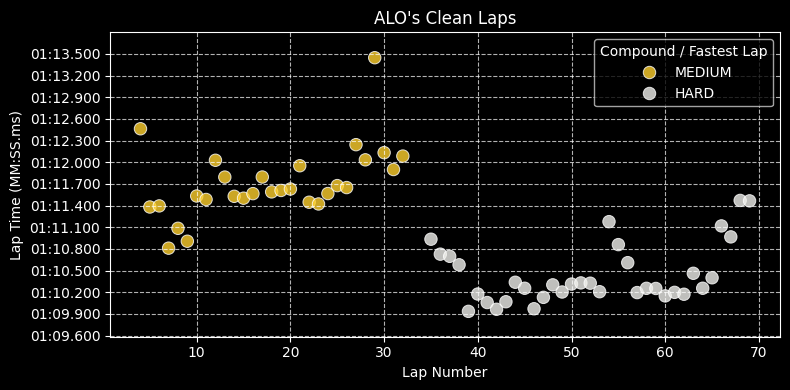

C:\Users\mpoli\AppData\Local\Temp\ipykernel_22088\4228898672.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  driver_laps['LapTime_formatted'] = driver_laps['LapTime_seconds'].apply(format_laptime_mmssms)


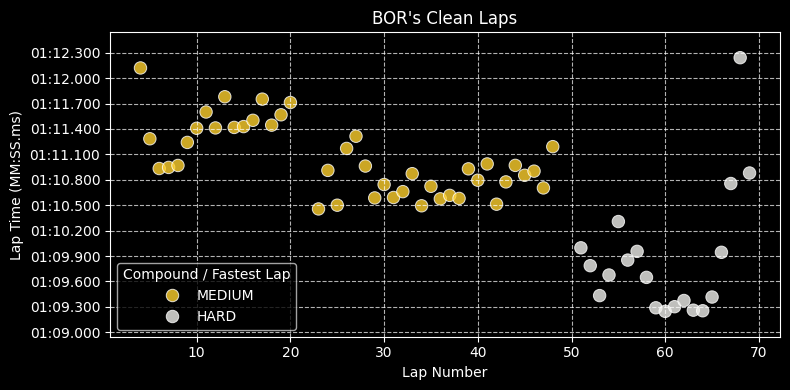

C:\Users\mpoli\AppData\Local\Temp\ipykernel_22088\4228898672.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  driver_laps['LapTime_formatted'] = driver_laps['LapTime_seconds'].apply(format_laptime_mmssms)


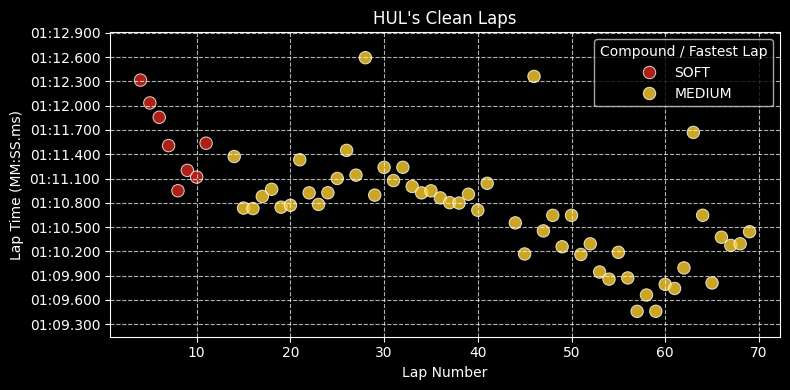

C:\Users\mpoli\AppData\Local\Temp\ipykernel_22088\4228898672.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  driver_laps['LapTime_formatted'] = driver_laps['LapTime_seconds'].apply(format_laptime_mmssms)


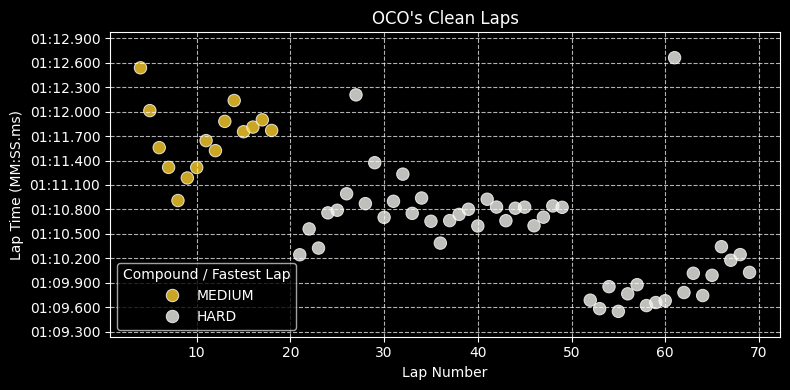

In [55]:

if current_session is not None:
    clean_laps = get_clean_laps(laps_df)  
    # Loading all drivers from the session
    drivers = current_session.drivers
    drivers = results_df['Abbreviation'].unique()  # Get unique drivers from results
    top_10_drivers = results_df['Abbreviation'].unique()[:10]  # Get the first 10 unique drivers from results
    print(top_10_drivers)
    for driver in top_10_drivers:
        driver_laps = clean_laps[clean_laps['Driver'] == driver]
        driver_laps['LapTime_formatted'] = driver_laps['LapTime_seconds'].apply(format_laptime_mmssms)
        if not driver_laps.empty:
            # 
            plt.figure(figsize=(8, 4))
            sns.scatterplot(data=driver_laps, 
                            x='LapNumber', 
                            y='LapTime_seconds', 
                            hue='Compound', 
                            markers={True: 'X', False: 'o'}, 
                            s=80, alpha=0.8, 
                            palette=COMPOUND_COLORS) 
            plt.title(f"{driver}""'s Clean Laps")
            plt.xlabel('Lap Number')
            plt.ylabel('Lap Time (MM:SS.ms)') 
            
            ax = plt.gca() 
            ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: format_laptime_mmssms(y)))
            
            if not driver_laps['LapTime_seconds'].empty:
                min_time = driver_laps['LapTime_seconds'].min()
                max_time = driver_laps['LapTime_seconds'].max()
                margin = (max_time - min_time) * 0.1
                ax.set_ylim(min_time - margin, max_time + margin)
                
                ## Ajusting the y-axis ticks to show every 0.3 seconds
                ax.yaxis.set_major_locator(MultipleLocator(0.3)) 

            plt.grid(True, linestyle='--', alpha=0.7)
            plt.legend(title='Compound / Fastest Lap') 
            plt.tight_layout()
            

            plt.show() 
else:
    print("No session has been loaded")



   Driver  Stint Compound  StintLength
0     ALB    1.0   MEDIUM           13
1     ALB    2.0   MEDIUM            2
2     ALO    1.0   MEDIUM           33
3     ALO    2.0     HARD           36
4     ANT    1.0   MEDIUM            1
5     BEA    1.0     SOFT           11
6     BEA    2.0     HARD           28
7     BEA    3.0   MEDIUM           30
8     BOR    1.0   MEDIUM           21
9     BOR    2.0   MEDIUM           28
10    BOR    3.0     HARD           20
11    COL    1.0     SOFT           13
12    COL    2.0   MEDIUM           26
13    COL    3.0     HARD           30
14    GAS    1.0     SOFT           12
15    GAS    2.0     HARD           26
16    GAS    3.0   MEDIUM           31
17    HAD    1.0     SOFT            2
18    HAD    2.0   MEDIUM           26
19    HAD    3.0     HARD           41
20    HAM    1.0   MEDIUM           26
21    HAM    2.0     HARD           24
22    HAM    3.0   MEDIUM           20
23    HUL    1.0     SOFT           12
24    HUL    2.0   MEDIUM

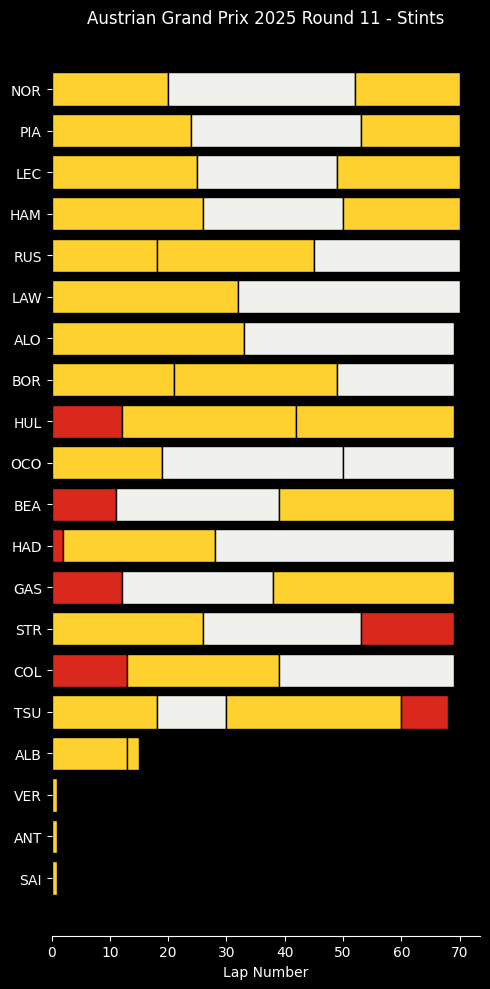

In [56]:
stints = laps_df[["Driver", "Stint", "Compound", "LapNumber"]]
stints = stints.groupby(["Driver", "Stint", "Compound"])
stints = stints.count().reset_index()

stints = stints.rename(columns={"LapNumber": "StintLength"})
print(stints)

fig, ax = plt.subplots(figsize=(5, 10))

for driver in drivers:
    driver_stints = stints.loc[stints["Driver"] == driver]

    previous_stint_end = 0
    for idx, row in driver_stints.iterrows():
        # each row contains the compound name and stint length
        # we can use these information to draw horizontal bars
        compound_color = fastf1.plotting.get_compound_color(row["Compound"],
                                                            session=current_session)
        plt.barh(
            y=driver,
            width=row["StintLength"],
            left=previous_stint_end,
            color=compound_color,
            edgecolor="black",
            fill=True
        )

        previous_stint_end += row["StintLength"]

plt.title(f'{current_session.event["EventName"]} {TARGET_YEAR} Round {TARGET_ROUND} - Stints')
plt.xlabel("Lap Number")
plt.grid(False)
# invert the y-axis so drivers that finish higher are closer to the top
ax.invert_yaxis()

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.tight_layout()
plt.show()